In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Set the path to your dataset
data_path = 'dataset3'

# Transformations, adjust as needed for your specific case

transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_dataset = datasets.ImageFolder(root=f'{data_path}/train', transform=transform)
val_dataset = datasets.ImageFolder(root=f'{data_path}/val', transform=transform)
test_dataset = datasets.ImageFolder(root=f'{data_path}/test', transform=transform)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=False)

In [2]:
# Get the original class labels
original_class_labels = train_dataset.classes

# Print the original class labels
print("Original class labels:", original_class_labels)


Original class labels: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [35]:
batch = next(iter(train_loader))
print(batch[0].shape)

torch.Size([32, 3, 150, 150])


In [6]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(128 * 18 * 18, 512)
        self.fc2 = nn.Linear(512, 4)
        self.pool = nn.MaxPool2d(2, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 18 * 18)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [7]:
from torch import nn
import matplotlib.pyplot as plt

def train_model(model, train_loader, valid_loader, num_epochs=10, learning_rate=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    if torch.cuda.is_available():
        print("CUDA")
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        print("MPS")
        device = torch.device("mps")
    else:
        print("CPU")
        device = torch.device("cpu")

    model = model.to(device)
    
    # Lists to track the losses and accuracies
    train_losses = []
    valid_losses = []
    train_accuracies = []
    valid_accuracies = []
    
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()  # Zero the parameter gradients
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        
        average_train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train
        train_losses.append(average_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()  # Set model to evaluate mode
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():  # No gradients needed for validation
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        average_val_loss = running_val_loss / len(valid_loader)
        val_accuracy = 100 * correct_val / total_val
        valid_losses.append(average_val_loss)
        valid_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch + 1}, Train Loss: {average_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {average_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
    
    return model, train_losses, valid_losses, train_accuracies, valid_accuracies


def save_model(model, directory="models"):
    os.makedirs(directory, exist_ok=True)
    
    highest_num = 0
    for filename in os.listdir(directory):
        if filename.startswith("model_") and filename.endswith(".pth"):
            num = int(filename.split('_')[1].split('.')[0])
            if num > highest_num:
                highest_num = num
    
    model_filename = f"model_{highest_num + 1}.pth"
    model_path = os.path.join(directory, model_filename)
    
    torch.save(model.state_dict(), model_path)
    print(f"Model saved as {model_filename} in directory '{directory}'.")


def load_model(model, model_number = None, directory="models"):
    if model_number is None:
        model_number = 0
        for filename in os.listdir(directory):
            if filename.startswith("model_") and filename.endswith(".pth"):
                num = int(filename.split('_')[1].split('.')[0])
                if num > model_number:
                    model_number = num

    model_filename = f"model_{model_number}.pth"
    model_path = os.path.join(directory, model_filename)
    if not os.path.exists(model_path):
        print(f"No model found with the name {model_filename} in directory '{directory}'.")
        return None
    model.load_state_dict(torch.load(model_path))
    print(f"Model loaded from {model_filename}.")
    return model


def test_model(model, test_loader):
    model.eval()  
    criterion = nn.CrossEntropyLoss()  

    if torch.cuda.is_available():
        device = torch.device("cuda")
    elif torch.backends.mps.is_available():
        device = torch.device("mps")
    else:
        device = torch.device("cpu")

    model = model.to(device)

    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad(): 
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    average_test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    print(f'Test Loss: {average_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')


def plot_metric(train_metric, valid_metric, metric_name, save_path='figures/img.png'):
    plt.figure(figsize=(10, 5))
    plt.plot(train_metric, label=f'Training {metric_name}')
    plt.plot(valid_metric, label=f'Validation Loss {metric_name}')
    plt.title(f'Training and Validation {metric_name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.savefig(save_path)

In [25]:
model = CNN()
model, train_losses, valid_losses, train_accuracies, valid_accuracies = train_model(model, train_loader, val_loader, num_epochs=4)

CUDA
Epoch 1, Train Loss: 0.6899, Train Acc: 75.28%, Val Loss: 0.4106, Val Acc: 85.23%
Epoch 2, Train Loss: 0.3352, Train Acc: 87.13%, Val Loss: 0.3192, Val Acc: 88.46%
Epoch 3, Train Loss: 0.2035, Train Acc: 92.89%, Val Loss: 0.2488, Val Acc: 91.43%
Epoch 4, Train Loss: 0.1169, Train Acc: 95.99%, Val Loss: 0.2784, Val Acc: 93.36%


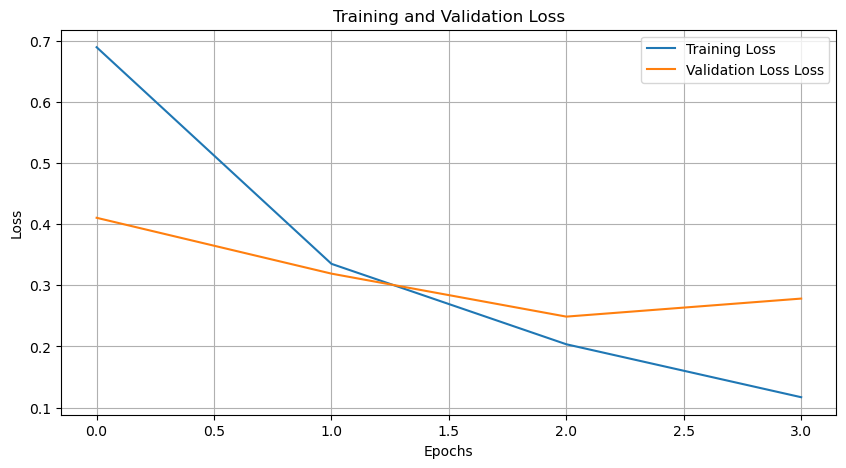

<Figure size 640x480 with 0 Axes>

In [62]:
plot_metric(train_losses, valid_losses, "Loss")

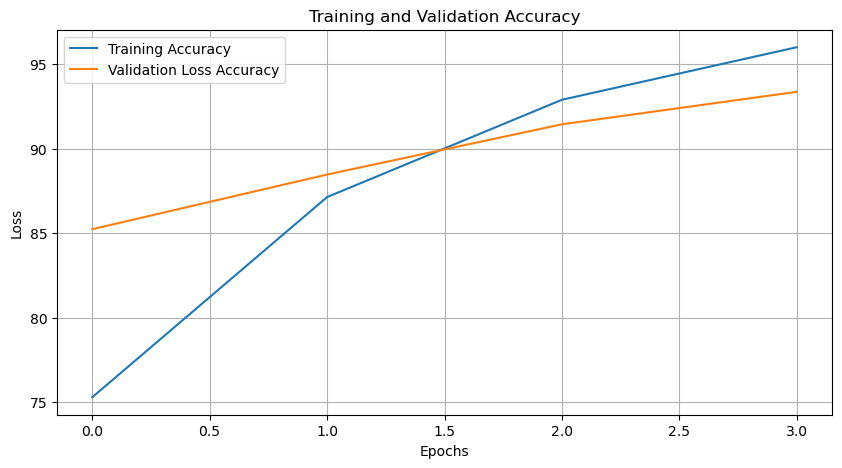

<Figure size 640x480 with 0 Axes>

In [64]:
plot_metric(train_accuracies, valid_accuracies, "Accuracy")

In [26]:
test_model(model, test_loader)

Test Loss: 0.2663, Test Accuracy: 92.26%


In [ ]:
save_model(model)

In [21]:
def inverse_normalize(tensor, mean, std):
    # Clone the tensor to avoid modifying the original tensor
    tensor = tensor.clone()

    # Unnormalize the tensor
    for i in range(tensor.size(0)):
        for j in range(tensor.size(1)):
            tensor[i, j] = tensor[i, j] * std[j] + mean[j]

    return tensor


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [81]:
print(next(iter(test_loader))

SyntaxError: incomplete input (656044409.py, line 1)

In [18]:
import matplotlib.pyplot as plt

def visualize_saliency(model, images, labels):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    num_examples = 4
    images, labels = images.to(device), labels.to(device)
    images, labels = images[:num_examples], labels[:num_examples]
    images.requires_grad_()

    
    model.eval()
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Saliency is the absolute value of the gradient
    saliency, _ = torch.max(images.grad.data.abs(), dim=1)
    
    images
    images_norm = inverse_normalize(images.clone(), mean, std)

    # Plot the images and their saliencies
    fig, ax = plt.subplots(2, len(images), figsize=(12, 4))
    for i in range(len(images)):
        ax[0, i].imshow(images_norm[i].detach().cpu().squeeze().permute(1, 2, 0))
        ax[0, i].axis('off')
        ax[1, i].imshow(saliency[i].detach().cpu().squeeze(), cmap='hot')
        ax[1, i].axis('off')
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have some test images and labels loaded)
images, labels = next(iter(test_loader))  # Load a batch of test images and labels
visualize_saliency(model, images, labels)


NameError: name 'inverse_normalize' is not defined

In [9]:
import os
model = CNN()
model = load_model(model, 5)

Model loaded from model_5.pth.


In [44]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def visualize_saliency(model, images, labels, mean, std):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    num_examples = 4
    images, labels = images.to(device), labels.to(device)
    images, labels = images[:num_examples], labels[:num_examples]
    images.requires_grad_()

    classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

    model.eval()
    outputs = model(images)
    predictions = outputs.argmax(dim=1)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Saliency is the absolute value of the gradient
    saliency, _ = torch.max(images.grad.data.abs(), dim=1)
    
    # Normalizing images for visualization
    images_norm = inverse_normalize(images, mean, std)  # inverse normalization

    # Plot the images and their saliencies
    fig, ax = plt.subplots(2, num_examples, figsize=(16, 8))  # Increased figure size
    for i in range(num_examples):
        ax[0, i].imshow(images_norm[i].cpu().detach().squeeze().permute(1, 2, 0))
        ax[0, i].axis('off')
        # ax[0, i].set_title(f'Pred Class: {classes[predictions[i]]} True: {classes[labels[i]]}', fontsize=10)  # Smaller font size
        ax[0, i].set_title(f'Class: {classes[labels[i]]}', fontsize=10)  # Smaller font size

        ax[1, i].imshow(saliency[i].cpu().detach().squeeze(), cmap='hot')
        ax[1, i].axis('off')
    
    plt.tight_layout(pad=3.0)  # Adjust layout to fit
    plt.show()

# Usage remains the same




In [36]:
test_loader = DataLoader(dataset=test_dataset, batch_size=32, shuffle=True)
iterator = iter(test_loader)


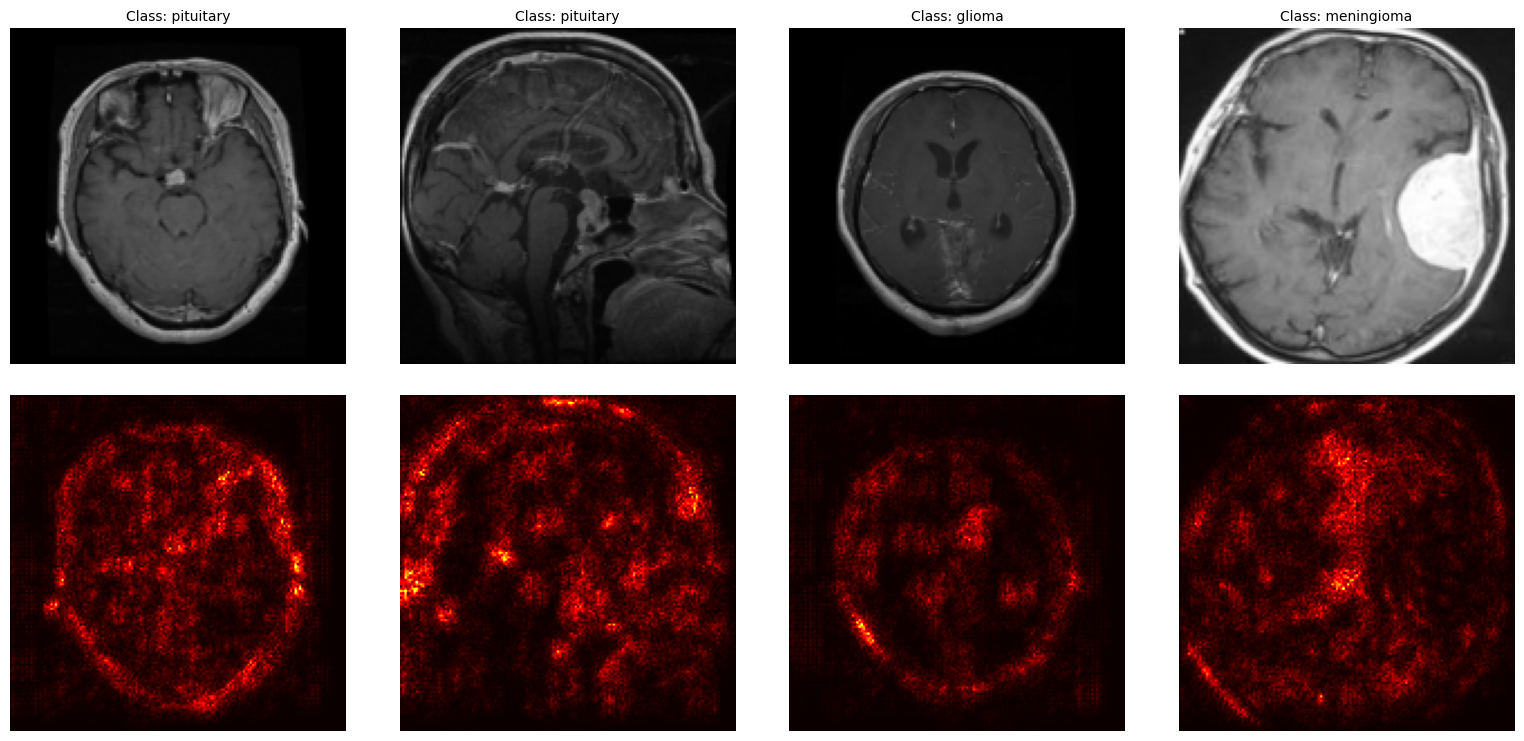

In [48]:
# Example usage (assuming you have some test images and labels loaded)
# Define 'mean' and 'std' based on your dataset normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
images, labels = next(iterator)  # Load a batch of test images and labels
visualize_saliency(model, images, labels, mean, std)

In [12]:
model = load_model()

TypeError: load_model() missing 1 required positional argument: 'model'

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

def visualize_saliency(model, images, labels, mean, std):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    num_examples = 4
    images, labels = images.to(device), labels.to(device)
    images, labels = images[:num_examples], labels[:num_examples]
    images.requires_grad_()

    model.eval()
    outputs = model(images)
    predictions = outputs.argmax(dim=1)
    loss = F.cross_entropy(outputs, labels)
    model.zero_grad()
    loss.backward()

    # Saliency is the absolute value of the gradient
    saliency, _ = torch.max(images.grad.data.abs(), dim=1)
    
    # Normalizing images for visualization
    images = (images - mean[:, None, None]) / std[:, None, None]  # inverse normalization

    # Plot the images and their saliencies
    fig, ax = plt.subplots(2, num_examples, figsize=(12, 4))
    for i in range(num_examples):
        ax[0, i].imshow(images[i].cpu().detach().squeeze().permute(1, 2, 0))
        ax[0, i].axis('off')
        ax[0, i].set_title(f'Pred: {predictions[i]} True: {labels[i]}')
        ax[1, i].imshow(saliency[i].cpu().detach().squeeze(), cmap='hot')
        ax[1, i].axis('off')
    plt.tight_layout()
    plt.show()

# Example usage (assuming you have some test images and labels loaded)
# Define 'mean' and 'std' based on your dataset normalization
mean = torch.tensor([0.485, 0.456, 0.406])
std = torch.tensor([0.229, 0.224, 0.225])
images, labels = next(iter(test_loader))  # Load a batch of test images and labels
visualize_saliency(model, images, labels, mean, std)


In [66]:
from sklearn.metrics import confusion_matrix
import numpy as np

def generate_confusion_matrix(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    model.eval()  # Set the model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # No gradients needed for testing
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate the confusion matrix
    confusion_mat = confusion_matrix(all_labels, all_preds)
    return confusion_mat

# Example usage
confusion_matrix = generate_confusion_matrix(model, test_loader)
print(confusion_matrix)


og_class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

[[260  36   2   2]
 [ 15 265  28   4]
 [  0   4 400   1]
 [  2   7   1 290]]


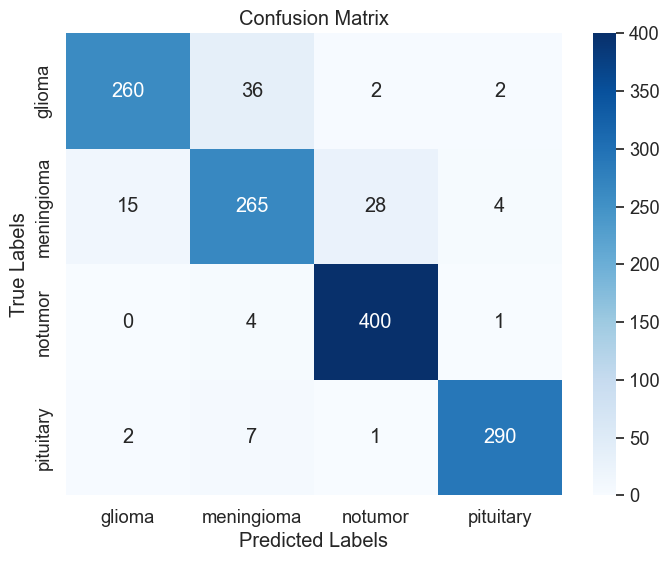

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay

# Define your original class labels
og_class_labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Plot the confusion matrix
def plot_confusion_matrix(confusion_matrix, class_labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale for better readability
    sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Example usage
plot_confusion_matrix(confusion_matrix, og_class_labels)


In [39]:
def print_model_parameters(model):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Total trainable parameters: {total_params}")
    # If you also want to include non-trainable parameters, you can remove the condition `if p.requires_grad`
    total_all_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters (including non-trainable): {total_all_params}")

# Example of using the function with your model
print_model_parameters(model)


Total trainable parameters: 21329476
Total parameters (including non-trainable): 21329476


In [69]:
train_dataset.__getitem__(0)

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,